In [247]:
import LR_model

In [248]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [249]:
data = pd.read_csv("./data.csv")
data = data.iloc[:, :-1]
data = data.drop(["id"], axis = 1)
data = data.dropna()
mapping = {'M': 1, 'B': 0}

X = data.drop("diagnosis", axis = 1)
y = data["diagnosis"].map(mapping)

se = StandardScaler()
se.fit(X)

X = se.transform(X)

In [250]:
def cv_(lr, X ,y, n, states, custom):
    acc, prec, rec, probs, all_weights, all_losses = [], [], [], [], [], []

    skf = StratifiedKFold(n_splits=n, shuffle=True, random_state=42)
    
    for train_index, test_index in skf.split(X, y):
           
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
                
        if(custom):
            lr.fit(X_train.tolist(), y_train.astype(bool).tolist())
            preds = lr.predict(X_test)
            
            all_losses.append(lr.get_loss())
            all_weights.append(lr.get_weigths())
            proba = [g.probability for g in preds]
            preds = [p.prediction for p in preds]
        else:
            lr.fit(X_train, y_train)
            preds = lr.predict(X_test)
        
            all_weights.append(np.append(lr.coef_[0], lr.intercept_[0]).tolist())
            proba = lr.predict_proba(X_test)[:, 1]

        acc.append(accuracy_score(y_test, preds))
        prec.append(precision_score(y_test, preds))
        rec.append(recall_score(y_test, preds))
        
        probs.append(proba)

    return [acc, prec, rec, probs, all_weights, all_losses]

In [251]:
lr = LR_model.LogisticRegression(10000, "lbfgs", 1.0, 0, 100, 1e-4, True)
lr_gradient = LR_model.LogisticRegression(10000, "gradientdescent", 1.0, 0.01, 0, 1e-4, True)
lr_sklearn = LogisticRegression(max_iter=1000, solver="lbfgs", tol=1e-4)

In [252]:
n = 10
states = list(range(1,n + 1))
lr_score = cv_( lr, X, y, n, states, True)
lr_gradient_score = cv_( lr_gradient, X, y, n, states, True)
lr_sklearn_score = cv_(lr_sklearn, X, y, n, states, False)

print(f"Accuracy:\n LBFGS: {np.mean(lr_score[0])} ; GradientDescent: {np.mean(lr_gradient_score[0])} ; Sklearn-LBFGS: {np.mean(lr_sklearn_score[0])}")
print(f"Precision:\n LBFGS: {np.mean(lr_score[1])} ; GradientDescent: {np.mean(lr_gradient_score[1])} ; Sklearn-LBFGS: {np.mean(lr_sklearn_score[1])}")
print(f"Recall:\n LBFGS: {np.mean(lr_score[2])} ; GradientDescent: {np.mean(lr_gradient_score[2])} ; Sklearn-LBFGS: {np.mean(lr_sklearn_score[2])}")

Accuracy:
 LBFGS: 0.9771929824561403 ; GradientDescent: 0.9701754385964912 ; Sklearn-LBFGS: 0.9771929824561403
Precision:
 LBFGS: 0.9824110671936758 ; GradientDescent: 0.9646479092989392 ; Sklearn-LBFGS: 0.9820158102766798
Recall:
 LBFGS: 0.9573593073593074 ; GradientDescent: 0.9573593073593074 ; Sklearn-LBFGS: 0.9573593073593074


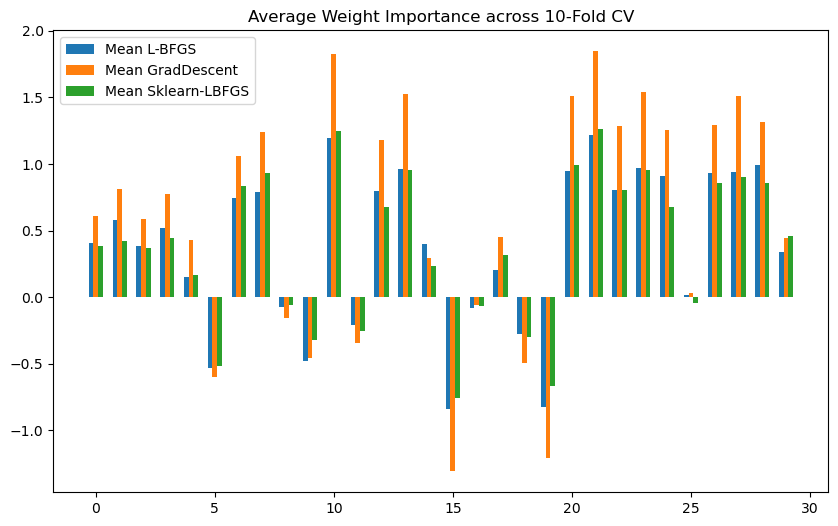

In [253]:
mean_lbfgs_weights = np.mean(lr_score[4], axis=0)[:-1]
mean_grad_weights = np.mean(lr_gradient_score[4], axis=0)[:-1]
mean_sklearn_weights = np.mean(lr_sklearn_score[4], axis=0)[:-1]

plt.figure(figsize=(10, 6))
x_axis = np.arange(X.shape[1])

plt.bar(x_axis - 0.2, mean_lbfgs_weights, 0.2, label='Mean L-BFGS')
plt.bar(x_axis, mean_grad_weights, 0.2, label='Mean GradDescent')
plt.bar(x_axis + 0.2, mean_sklearn_weights, 0.2, label='Mean Sklearn-LBFGS')

plt.title(f"Average Weight Importance across {n}-Fold CV")
plt.legend()
plt.show()

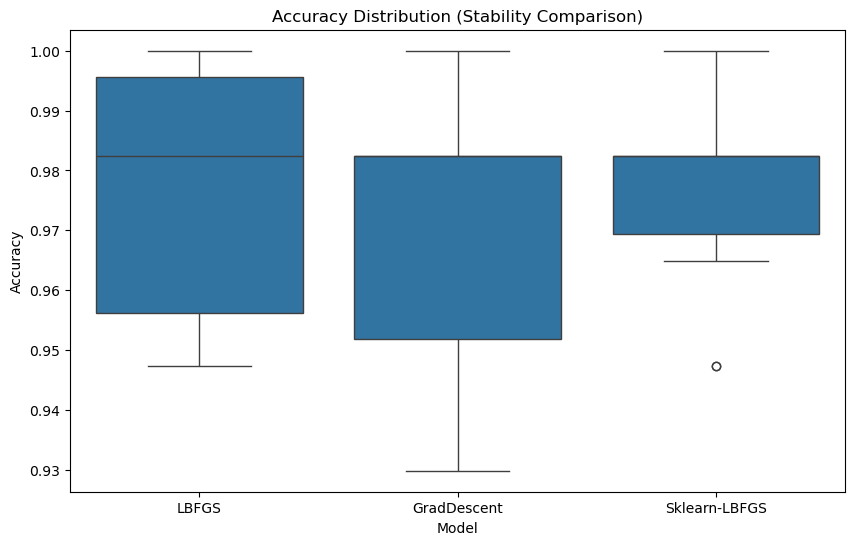

In [254]:
data = {
    'Accuracy': lr_score[0] + lr_gradient_score[0] + lr_sklearn_score[0],
    'Model': ['LBFGS']*n + ['GradDescent']*n + ['Sklearn-LBFGS']*n
}

df_results = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
sns.boxplot(x='Model', y='Accuracy', data=df_results)
plt.title('Accuracy Distribution (Stability Comparison)')
plt.show()

In [255]:
def get_mean_loss(history_list):
    max_len = max(len(h) for h in history_list)
    padded_histories = []
    for h in history_list:
        if len(h) < max_len:
            h = np.append(h, [h[-1]] * (max_len - len(h)))
        padded_histories.append(h)
    
    return np.mean(padded_histories, axis=0)


mean_lbfgs = get_mean_loss(lr_score[5]) 
mean_gd = get_mean_loss(lr_gradient_score[5])

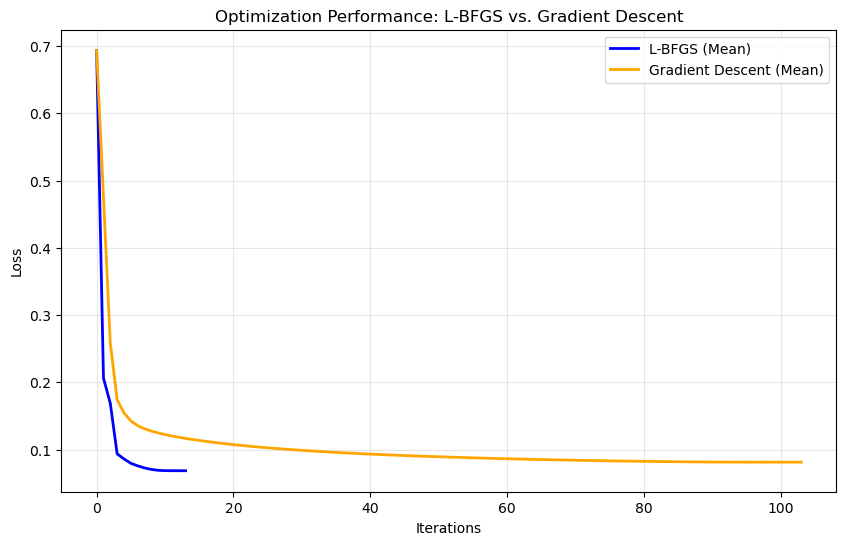

In [256]:
plt.figure(figsize=(10, 6))

plt.plot(mean_lbfgs, label='L-BFGS (Mean)', color='blue', linewidth=2)
plt.plot(mean_gd, label='Gradient Descent (Mean)', color='orange', linewidth=2)

#plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Optimization Performance: L-BFGS vs. Gradient Descent')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.3)
plt.show()